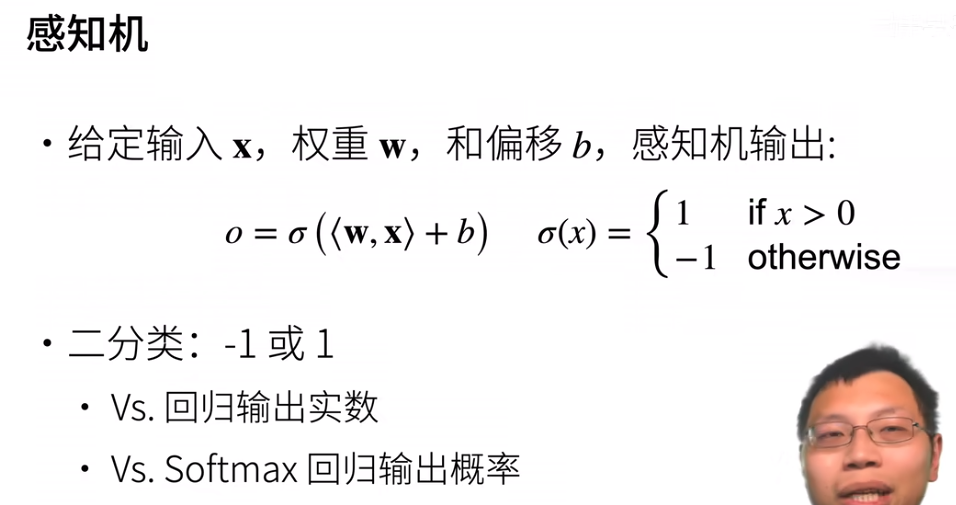
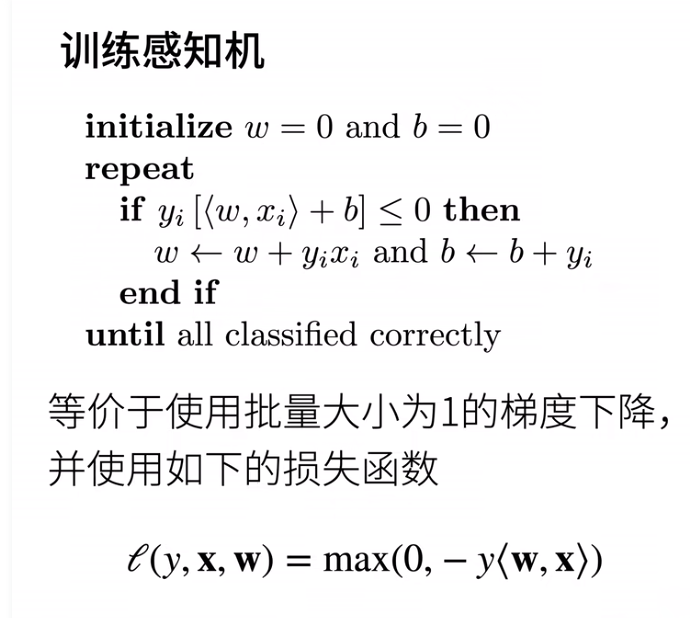
#### 这里max对于上面if语句，因为当分类正确，-y<w,x> 小于0 ，损失函数为0，梯度为0
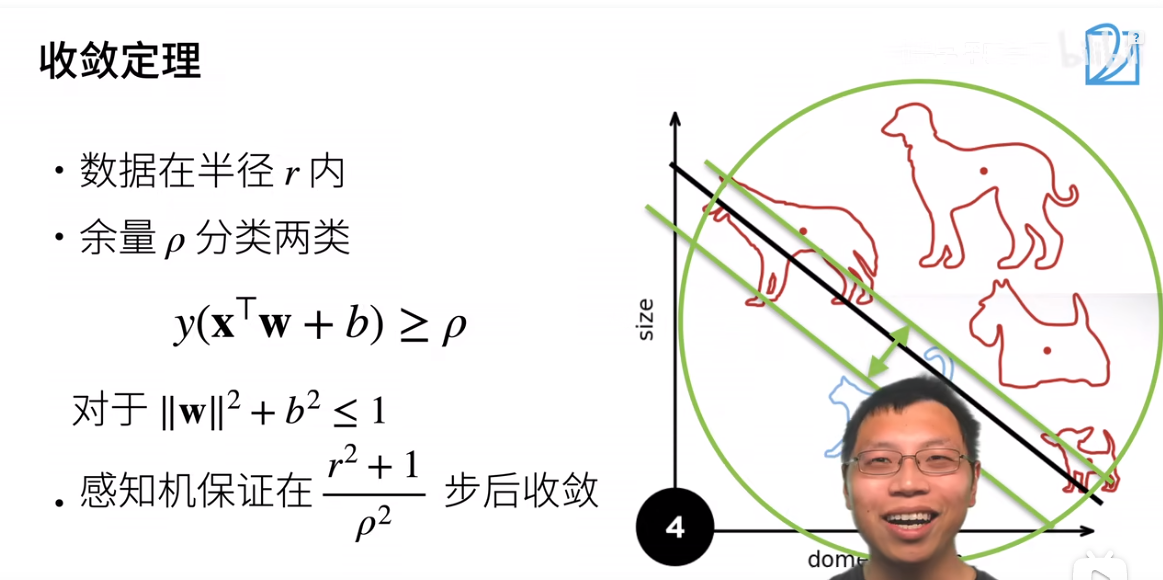

#### 感知机不能拟合XOR函数，它只能产生线性分割面
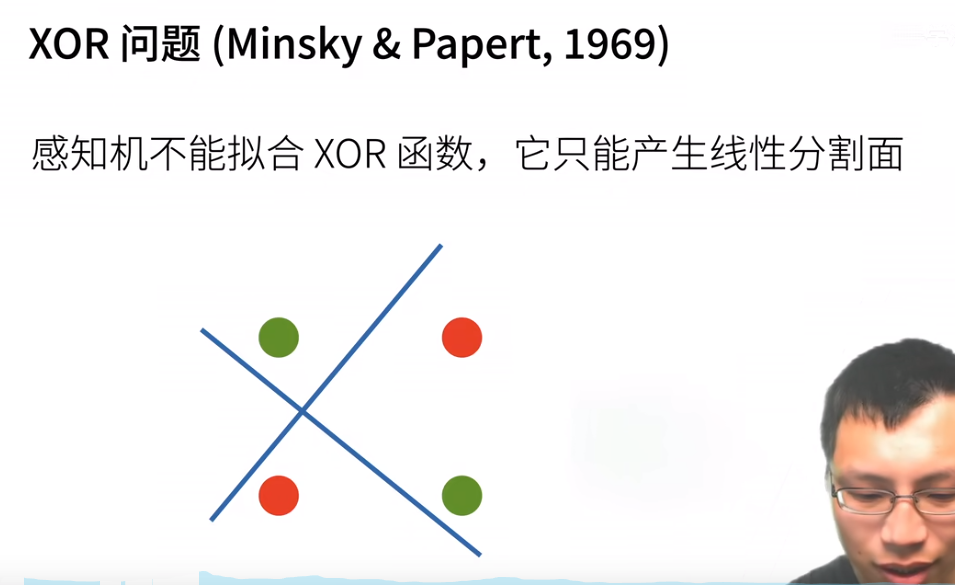

#多层感知机隐藏层大小是超参数
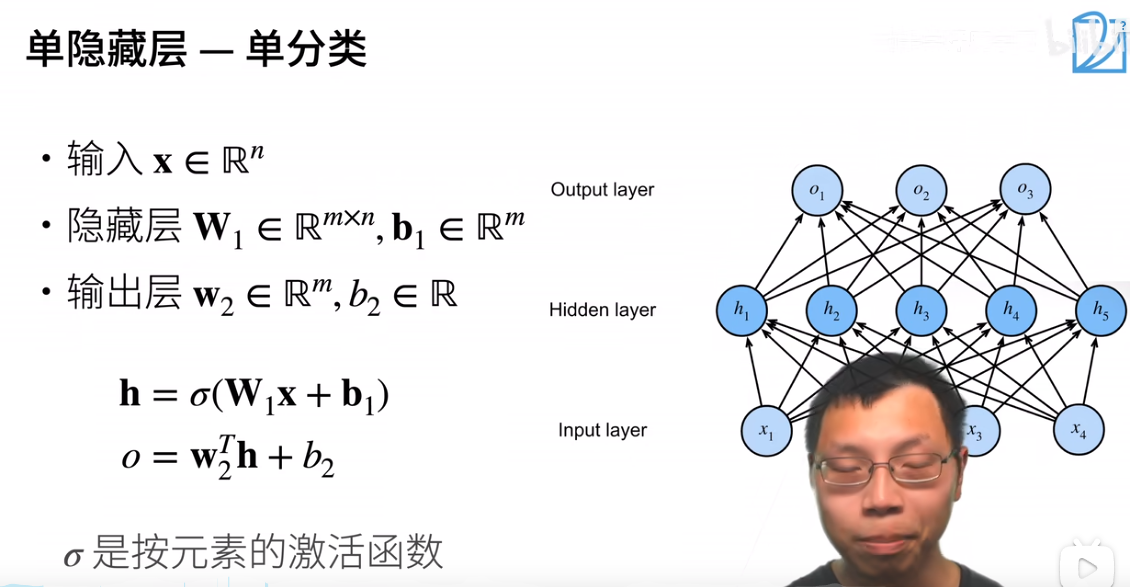

In [12]:
#定义一个绘图函数
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
def xyplot(x, y, name):
    plt.figure(figsize=(5,2.5))
    plt.plot(x.detach(),y.detach())
    plt.xlabel('x')
    plt.ylabel(name+'(x)')

#激活函数
#Sigmoid函数 
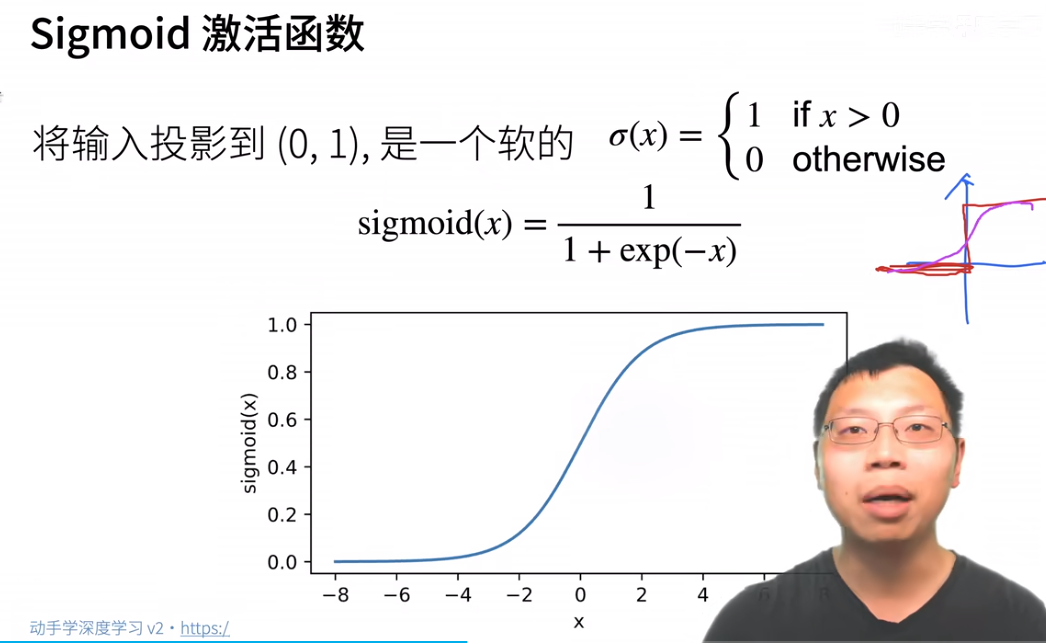

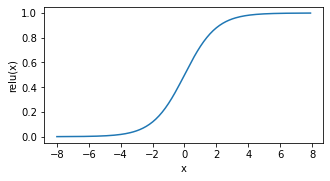

In [13]:
x = torch.arange(-8.0,8,0.1,requires_grad=True)
y = x.sigmoid()
xyplot(x,y,"relu")

# tanh函数
##### tanh(x)'=1-tanh(x)
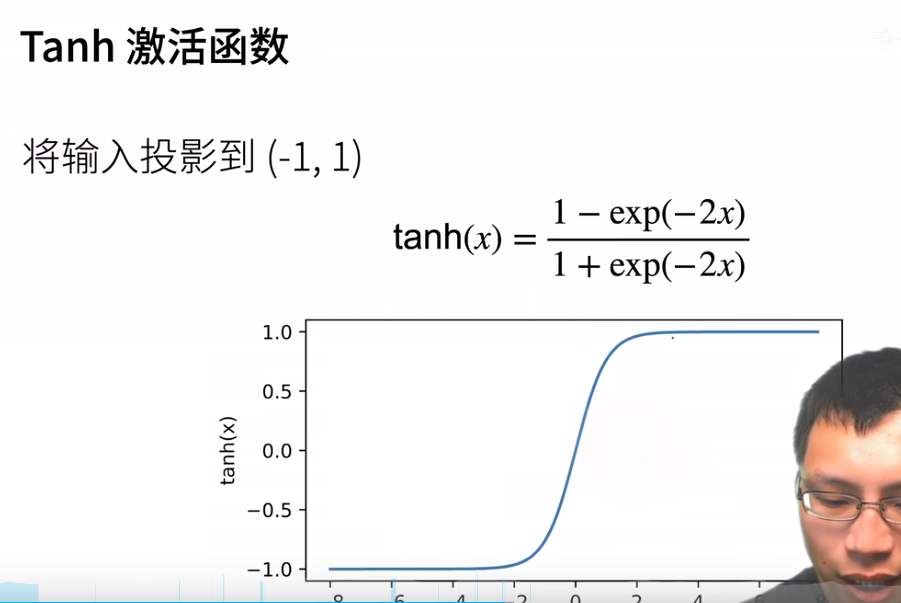

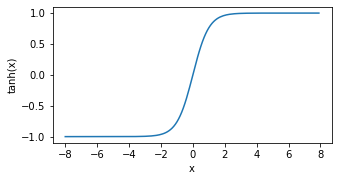

In [14]:
y = x.tanh()
xyplot(x,y,"tanh")

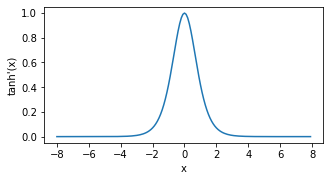

In [17]:
y = 1-pow(x.tanh(),2)
xyplot(x,y,"tanh'")

# ReLu函数
#### 计算很快
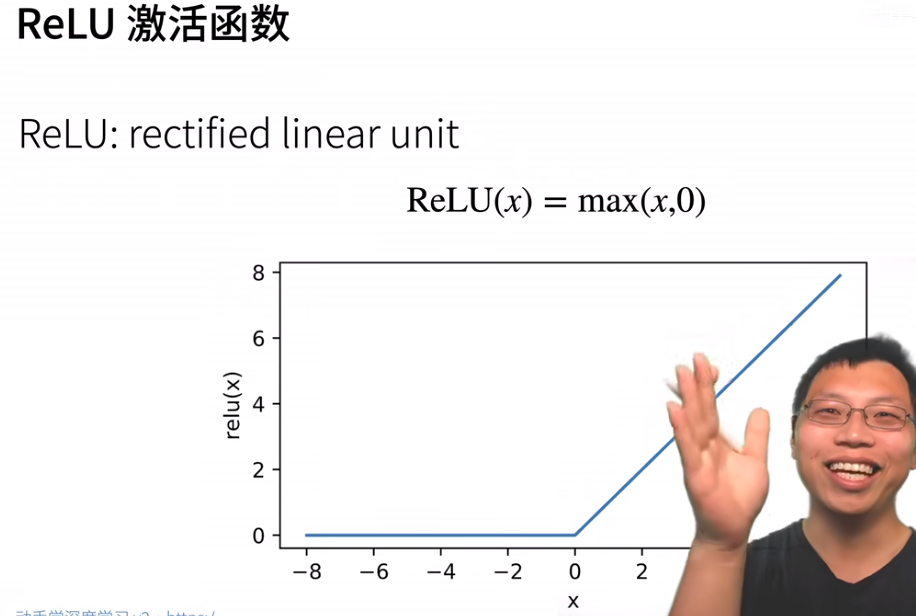

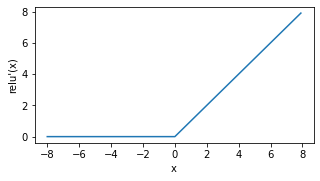

In [19]:
y = x.relu()
xyplot(x,y,"relu'")

# 多层感知机
#### 激活函数主要用于避免层数塌陷，因此输出层不需要激活函数
#### 超参数：隐藏层数，每层隐藏层大小
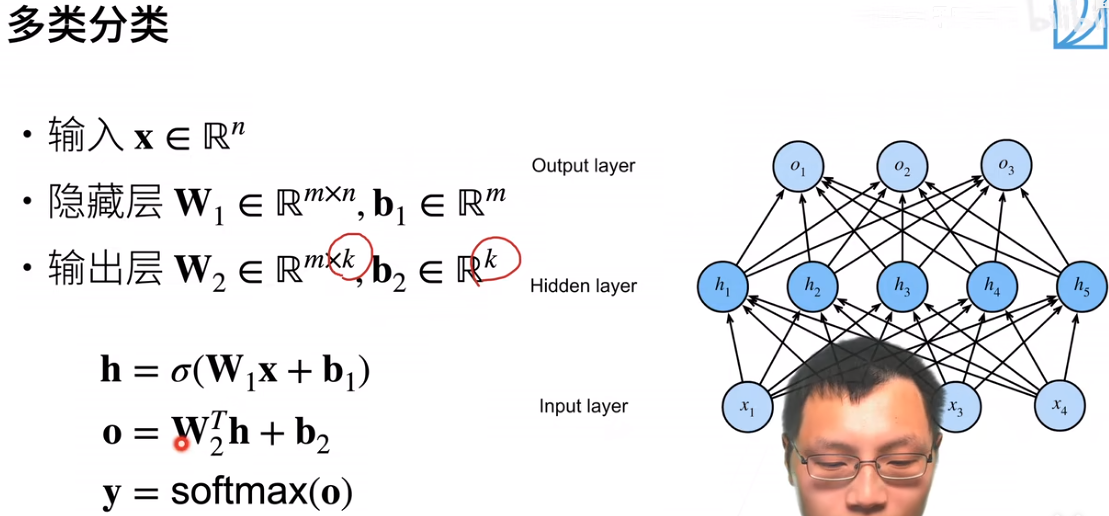

In [23]:
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)

In [24]:
batch_size = 256
train_iter = data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True)
test_iter = data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True)

In [26]:
#但隐藏层多层感知机实现
num_inputs = 784
num_outputs=10
hiddens=256
w1 = torch.normal(0,0.01,(num_inputs,hiddens),requires_grad=True)
b1 = torch.zeros(hiddens,requires_grad=True)
w2 = torch.normal(0,0.01,(hiddens,num_outputs),requires_grad=True)
b2 = torch.zeros(num_outputs,requires_grad=True)
params = [w1,b1,w2,b2]

In [36]:
#实现relu激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(a,X)

In [52]:
def net(X):
    X = X.reshape(-1,num_inputs)
    H = relu(torch.matmul(X,w1)+b1)
    return torch.matmul(H,w2)+b2

In [53]:
import torch.nn as nn
loss = nn.CrossEntropyLoss()

In [56]:
#计算损失->梯度清零——>损失梯度回传->梯度优化
def sgd(params,lr,batch_size):#params表示要进行梯度下降优化的参数列表
    with torch.no_grad(): #此时不需要梯度回传
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()
def accuracy(y_hat,y):
    return ((y_hat.argmax(axis=1)==y).float().mean().item()) #item()将张量变成数值
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module): #如果模型是用模块实现的
        net.eval() #将模型设置为评估模型，不计算梯度
    acc, n = 0.0, 0
    for x,y in data_iter:
        acc += accuracy(net(x),y)
        n += 1
    return acc/n
def train_ch3(net, train_iter, test_iter, loss, num_epoches, params=None, lr=None,optimizer=None):
    for epoch in range(num_epoches):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for x,y in train_iter:
            y_hat = net(x)
            l = loss(y_hat,y).sum()
            if optimizer != None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for para in params:
                    para.grad.data.zero_()
            l.backward()
            if optimizer != None:
                optimizer.step()
            else:
                sgd(params,lr,256)
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(net, test_iter)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n,test_acc))
#         animator.add(epoch+1,[ train_l_sum / n, train_acc_sum / n]+[test_acc])
train_ch3(net,train_iter,test_iter,loss,num_epoches=10, params=params,lr=50)

epoch 1, loss 0.0034, train acc 0.694, test acc 0.754
epoch 2, loss 0.0021, train acc 0.814, test acc 0.820
epoch 3, loss 0.0018, train acc 0.834, test acc 0.813
epoch 4, loss 0.0017, train acc 0.847, test acc 0.821
epoch 5, loss 0.0016, train acc 0.858, test acc 0.828
epoch 6, loss 0.0015, train acc 0.864, test acc 0.845
epoch 7, loss 0.0014, train acc 0.867, test acc 0.816
epoch 8, loss 0.0014, train acc 0.871, test acc 0.844
epoch 9, loss 0.0013, train acc 0.875, test acc 0.848
epoch 10, loss 0.0013, train acc 0.878, test acc 0.853


In [60]:
#简洁实现
net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),nn.Linear(256,10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [62]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

In [63]:
train_ch3(net,train_iter,test_iter,loss,num_epoches=10, optimizer=optimizer)

epoch 1, loss 0.0084, train acc 0.358, test acc 0.500
epoch 2, loss 0.0060, train acc 0.570, test acc 0.608
epoch 3, loss 0.0044, train acc 0.638, test acc 0.639
epoch 4, loss 0.0036, train acc 0.669, test acc 0.669
epoch 5, loss 0.0033, train acc 0.691, test acc 0.683
epoch 6, loss 0.0030, train acc 0.714, test acc 0.714
epoch 7, loss 0.0029, train acc 0.734, test acc 0.732
epoch 8, loss 0.0027, train acc 0.751, test acc 0.748
epoch 9, loss 0.0026, train acc 0.765, test acc 0.763
epoch 10, loss 0.0025, train acc 0.776, test acc 0.771
